# Figure 2: Observed and simulated changes in sea ice

Figure 2 of ice shelf melt perturbation study:
    - observed sea ice concentration trend (1992-2011)
    - modelled sea ice concentration trend (1992-2011), control run
    - change in sea ice concentration (perturbation-control)
    - change in sea ice volume (perturbation-control)

Observations are taken from the National Snow and Ice Data Centre (https://nsidc.org/). The monthly trend is calculcated in `calc_sic_NSIDC_trend.py`.

The change in sea ice concentration in the observations and the control run is calculated as the linear trend multiplied by the number of years. The change in sea ice concentration/volume between the perturbation and the control simulation is simply their difference.

This python script is based on `plot_seaice_NSIDC_MetROMS.py`.

In [1]:
# Load modules
import sys
sys.path.insert(0, '/g/data/gh9/wgh581/Python_code/plot_code/metroms_code')
from fxn_cartesian_grid_2d import *
from numpy import *
from matplotlib.pyplot import *
import matplotlib.gridspec as gridspec
from netCDF4 import Dataset
import cmocean.cm as cmo
import copy
import xarray as xr
import scipy.signal
import scipy.stats

## Import data

In [2]:
# Names for plotting
season = ['DJF', 'MAM', 'JJA', 'SON']
label  = ['CNTR', 'PERT']
panel_name = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', \
        'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)']

#### 1) MetROMS perturbation

In [3]:
# Path
path = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/'
# CICE seasonal climatology
CNTR = 'cice_climatology_CONTROL_2008_2011.nc'#2007_2009.nc'
PERT = 'cice_climatology_2SSFLUX_2008_2011.nc'#'cice_climatology_4SSFLUX_2008_2011.nc'#2007_2009.nc'
filename = [path + 'POST_PROCESS/' + CNTR, path + 'POST_PROCESS/' + PERT]
# CICE grid (random cice history file)
cice_grid = path + 'RAW/metroms_CONTROL/cice/history/iceh.2007-01-01.nc'
# MetROMS grid (random ocean history file)
roms_grid = path + 'RAW/metroms_CONTROL/ocean_his_0042.nc'

In [4]:
# Read the CICE grid
id   = Dataset(cice_grid, 'r')
lon  = id.variables['TLON'][:-15,:-1]
lat  = id.variables['TLAT'][:-15,:-1]
lon_cice = id.variables['TLON'][:,:]
lat_cice = id.variables['TLAT'][:,:]
id.close()

In [5]:
# Degrees to radians conversion
deg2rad = pi/180.0

# Convert to spherical coordinates for plotting
x = -(lat+90)*cos(lon*deg2rad+pi/2)
y = (lat+90)*sin(lon*deg2rad+pi/2)
x_cice = -(lat_cice+90)*np.cos(lon_cice*deg2rad+np.pi/2)
y_cice = (lat_cice+90)*np.sin(lon_cice*deg2rad+np.pi/2)

In [6]:
# Calculate area
dx, dy = cartesian_grid_2d(lon, lat)
dA = dx * dy

In [7]:
# Load CICE data for plotting
# Minimum value for sea ice extent
aice_extmin = 0.15#0.001#0.15
for ii in range(len(filename)):
    print('Working on %s'%label[ii])
    id = Dataset(filename[ii], 'r')
    aice_tmp = id.variables['aice'][:,:-15,:-1]
    hi_tmp = id.variables['hi'][:,:-15,:-1]
    id.close()
    # 1.1 Calculate volume and convert to km^3
    #siv_tmp = aice_tmp * hi_tmp * dA  * 1e-9
    # 1.2 Calculate effective volume (units: m)
    siv_tmp = aice_tmp * hi_tmp
    if ii == 0:
        aice = aice_tmp
        hi   = hi_tmp
        siv  = siv_tmp
    elif ii == 1:
        aice = [aice, aice_tmp]
        hi   = [hi, hi_tmp]
        siv  = [siv, siv_tmp]

print('mean(siv): ', mean(siv))
print('max(siv): ', amax(siv))

Working on CNTR
Working on PERT
mean(siv):  3.4949360490343666e+36
max(siv):  9.969209968386869e+36


In [8]:
# Load Metroms grid, bathymetry, and zice
id = Dataset(roms_grid, 'r')
lat_roms = id.variables['lat_rho'][:-15,:-1]
lon_roms = id.variables['lon_rho'][:-15,:-1]
h    = id.variables['h'][:-15,:-1]
zice = id.variables['zice'][:-15,:-1]
mask = id.variables['mask_rho'][:-15,:-1]
id.close()
# Spherical coordinates
x_roms = -(lat_roms+90)*cos(lon_roms*deg2rad+pi/2)
y_roms = (lat_roms+90)*sin(lon_roms*deg2rad+pi/2)
# Masking
h = ma.masked_where(mask==0, h)
zice = ma.masked_where(mask==0, zice)
zice = ma.masked_where(zice==0, zice)
lat_r = ma.masked_where(mask==1, lat_roms)
# Center of missing circle (metroms)
lat_c   = -83
lon_c   = 50
# Radius of missing circle (play around with this until it works)
radius  = 10.1
# Find center in spherical coordinates
x_c_metroms = -(lat_c+90)*np.cos(lon_c*deg2rad+np.pi/2)
y_c_metroms = (lat_c+90)*np.sin(lon_c*deg2rad+np.pi/2)
# Build a regular x-y grid and select the missing circle
lat_max = -63+90
x_reg, y_reg = np.meshgrid(np.linspace(-lat_max, lat_max, num=1000), np.linspace(-lat_max, lat_max, num=1000))
land_circle = np.zeros(np.shape(x_reg))
land_circle_metroms = np.ma.masked_where(np.sqrt((x_reg-x_c_metroms)**2 + (y_reg-y_c_metroms)**2) > radius, land_circle)

#### 2) MetROMS control trend

In [9]:
# Import monthly aice model data
data_1992_2002 = xr.open_dataset(path + 'POST_PROCESS/aice_1992_2002_CONTROL_monthly.nc').aice
data_2002_2012 = xr.open_dataset(path + 'POST_PROCESS/aice_2002_2012_CONTROL_monthly.nc').aice[:-11,:,:]

# Concatenate along time dimension (time is reversed)
aice_control = xr.concat([data_2002_2012, data_1992_2002], dim="time")

# Monthly climatology
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
trend  = np.zeros((np.size(months), np.size(aice_control,1), np.size(aice_control,2)))
aice_monthly = np.zeros((np.size(months), np.size(aice_control,1), np.size(aice_control,2)))

# Deal with nan (set to dummy value)
aice_control = aice_control.fillna(-999)

In [10]:
# Calculate trend
for nn in range(np.size(months)):

    #print('Working on: ', months[::-1][nn])
    tmp = aice_control[nn::12].values
    aice_monthly[11-nn,:,:] = tmp.mean(axis=0)
    tmp_d = scipy.signal.detrend(tmp, axis=0)
    detrn = tmp - tmp_d

    # Get the slope (backwards as the time vector goes from present to past)
    # January is last in monthly time series
    trend[11-nn,:,:] = (detrn[0,:,:] - detrn[-1,:,:]) / np.size(detrn, axis=0)

# Seasonal trend
season = ['DJF', 'MAM', 'JJA', 'SON']
trend_seasonal = np.zeros((len(season), np.size(aice_control,1), np.size(aice_control,2)))
trend_seasonal[0,:,:] = (trend[11,:,:] + trend[0,:,:] + trend[1,:,:]) / 3
trend_seasonal[1,:,:] = np.mean(trend[2:5,:,:], axis=0)
trend_seasonal[2,:,:] = np.mean(trend[5:8,:,:], axis=0)
trend_seasonal[3,:,:] = np.mean(trend[8:11,:,:], axis=0)

# Seasonal concentration (for masking below, to indicate sea ice edge)
aice_seasonal = zeros((len(season), size(aice_control,1), size(aice_control,2)))
aice_seasonal[0,:,:] = aice_monthly[[11, 0, 1],:,:].mean(axis=0)
aice_seasonal[1,:,:] = aice_monthly[[2, 3, 4],:,:].mean(axis=0)
aice_seasonal[2,:,:] = aice_monthly[[5, 6, 7],:,:].mean(axis=0)
aice_seasonal[3,:,:] = aice_monthly[[8, 9, 10],:,:].mean(axis=0)

# Masking
for tt in range(4):
    tmp = trend_seasonal[tt,:,:]
    tmp[aice_seasonal[tt,:,:] < aice_extmin] = np.nan
    trend_seasonal[tt,:,:] = tmp

# Convert to dataarray
trend_seasonal = xr.DataArray(trend_seasonal, dims=('time', 'nj', 'ni'), \
    coords={'time':season, 'TLAT':aice_control.TLAT, 'TLON':aice_control.TLON}, name='aice')

#### 3) NSIDC

In [11]:
# Path
nsidc_path = '/g/data/gh9/wgh581/NSIDC_monthly/'

# Load grid information from a (random) original file
id = Dataset(nsidc_path + 'seaice_conc_monthly_sh_f08_199101_v03r01.nc', 'r')
lon_sic = id.variables['longitude'][:]
lat_sic = id.variables['latitude'][:]
id.close()

In [12]:
# Load trend
#id = Dataset(nsidc_path + 'sic_trend_1979_2015.nc')
id = Dataset(nsidc_path + 'sic_trend_1992_2011.nc')
sic = id.variables['sic'][:]
id.close
# Calculate seasonal average
seas = zeros((4, 332, 316))
seas[0,:,:] = nanmean(sic[[0, 1, 11],:,:], axis=0)
seas[1,:,:] = nanmean(sic[[2, 3, 4],:,:], axis=0)
seas[2,:,:] = nanmean(sic[[5, 6, 7],:,:], axis=0)
seas[3,:,:] = nanmean(sic[[8, 9, 10],:,:], axis=0)

# Get delta SIC = trend * ntime
ntime_NSIDC = 2011-1992+1 #2015-1979+1
delta_SIC_NSIDC = seas * ntime_NSIDC

# sic climatology to indicate ice shelf edge on plot
#id = Dataset(nsidc_path + 'sic_climatology_1979_2015.nc')
id = Dataset(nsidc_path + 'sic_climatology_1992_2011.nc')
sic_monthly = id.variables['sic'][:]
id.close()
sic_seasonal = zeros((len(season), size(sic_monthly,1), size(sic_monthly,2)))
sic_seasonal[0,:,:] = sic_monthly[[11, 0, 1],:,:].mean(axis=0)
sic_seasonal[1,:,:] = sic_monthly[[2, 3, 4],:,:].mean(axis=0)
sic_seasonal[2,:,:] = sic_monthly[[5, 6, 7],:,:].mean(axis=0)
sic_seasonal[3,:,:] = sic_monthly[[8, 9, 10],:,:].mean(axis=0)

In [13]:
# Masking
for tt in range(4):
    tmp = delta_SIC_NSIDC[tt,:,:]
    tmp[sic_seasonal[tt,:,:] < aice_extmin] = np.nan
    delta_SIC_NSIDC[tt,:,:] = tmp
diff_aice = aice[1] - aice[0]
diff_aice[aice[0] < aice_extmin] = np.nan
diff_siv = siv[1] - siv[0]
diff_siv[aice[0] < aice_extmin] = np.nan

#### 4) Scatter points for shelf break

In [14]:
ind_i = load(path + 'POST_PROCESS/ind_i_1000m_reorder_picked.npy')
ind_j = load(path + 'POST_PROCESS/ind_j_1000m_reorder_picked.npy')
BS_i  = ind_i[1110:1180]
BS_j  = ind_j[1110:1180]
PIG_i = ind_i[1060:1110]
PIG_j = ind_j[1060:1110]
AS_i  = ind_i[920:1060]
AS_j  = ind_j[920:1060]
ERS_i = ind_i[860:920]
ERS_j = ind_j[860:920]
WRS_i = ind_i[760:860]
WRS_j = ind_j[760:860]
x_BS, y_BS   = where((lat_roms < -69.5) & (lon_roms > lon_roms[BS_i[3],BS_j[3]]) &\
                     (lon_roms < lon_roms[BS_i[-1],BS_j[-1]]) & (h < 1000))
x_PIG, y_PIG = where((lat_roms < -69.5) & (lon_roms > lon_roms[PIG_i[0],PIG_j[0]]) &\
                     (lon_roms < lon_roms[PIG_i[-1],PIG_j[-1]]) & (h < 1000))
x_AS, y_AS   = where((lat_roms < -71.5) & (lon_roms > lon_roms[AS_i[0],AS_j[0]]) &\
                     (lon_roms < lon_roms[AS_i[-1],AS_j[-1]]) & (h < 1000))
x_ERS, y_ERS = where((lat_roms < -74.5) & (lon_roms > lon_roms[ERS_i[0],ERS_j[0]]) &\
                     (lon_roms < lon_roms[ERS_i[-1],ERS_j[-1]]) & (h < 1000))
#x_WRS, y_WRS = where((lat_roms < -72.0) & (lon_roms > lon_roms[WRS_i[0],WRS_j[0]]) &\
#                     (lon_roms < lon_roms[WRS_i[-1],WRS_j[-1]]) & (h < 1000))
x_WRS, y_WRS = where((lat_roms < -72.0) & (lon_roms > lon_roms[ind_i[650],ind_j[650]]) &\
                     (lon_roms < lon_roms[WRS_i[-1],WRS_j[-1]]) & (h < 1000))

# Get circumpolar x and y coordinates for plotting
x_sic = -(lat_sic+90)*cos(lon_sic*deg2rad+pi/2)
y_sic = (lat_sic+90)*sin(lon_sic*deg2rad+pi/2)

## Plotting

In [15]:
# Fontsize
ft_size = 14

# Colormap
from palettable.scientific.diverging import Vik_19_r

# Resolution when saving figure
my_dpi = 150

/jobfs/83113665.gadi-pbs/ipykernel_3646989/1417157768.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_sic, y_sic, delta_SIC_NSIDC[ii,:,:], cmap=Vik_19_r.mpl_colormap, \
/jobfs/83113665.gadi-pbs/ipykernel_3646989/1417157768.py:36: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, trend_seasonal[ii,:,:]*20, cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5)
/jobfs/83113665.gadi-pbs/ipykernel_3646989/1417157768.py:60: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing o

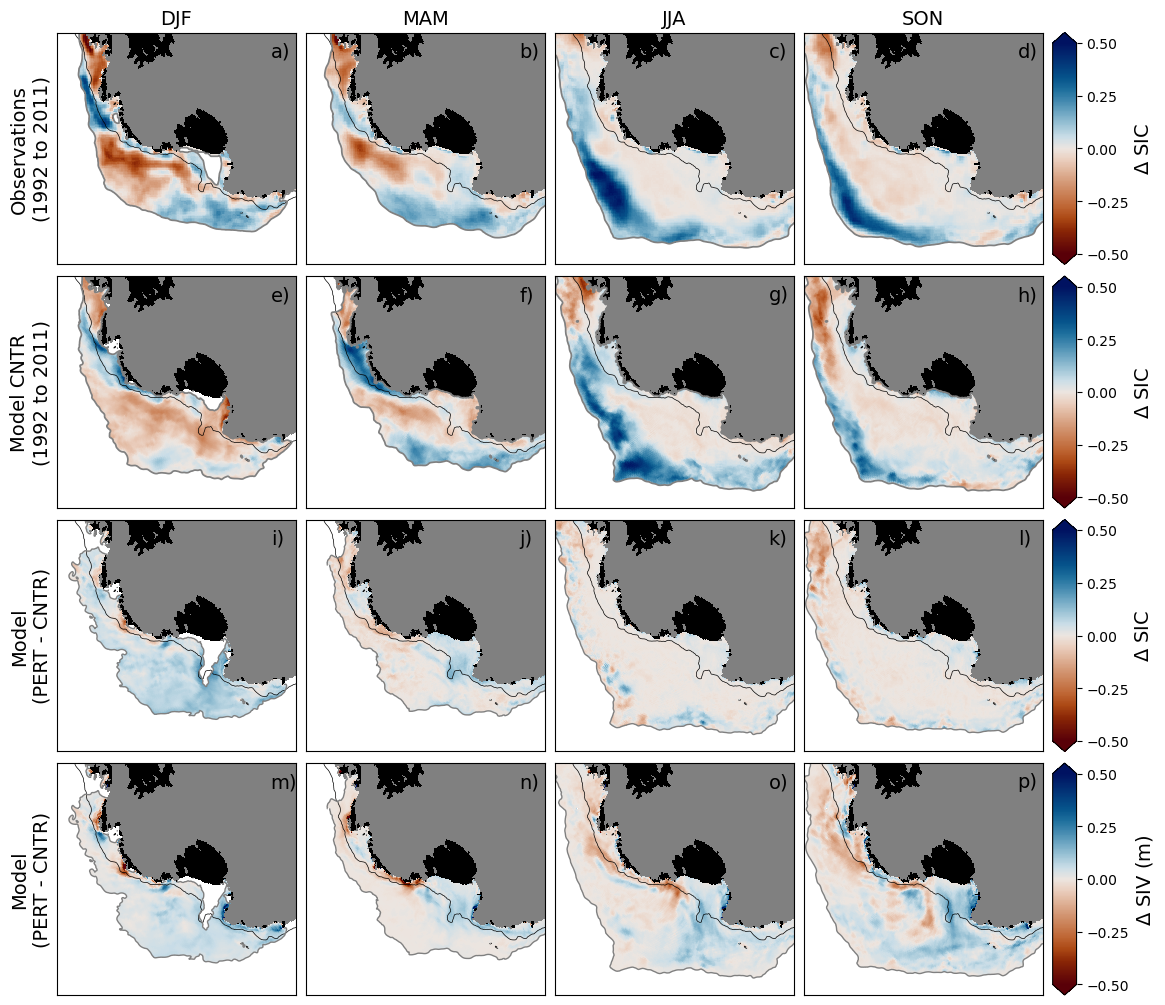

In [17]:
fig = figure(figsize=(12,11)) #(12,9)
gs  = gridspec.GridSpec(4, 1, height_ratios=[1,1,1,1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[2], wspace=0.05)
gs3 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[3], wspace=0.05)

for ii in range(len(season)):

    # Observations, delta SIC
    ax = fig.add_subplot(gs0[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii], fontsize=ft_size, transform=ax.transAxes)
    title(season[ii], fontsize=ft_size)
    sc = pcolormesh(x_sic, y_sic, delta_SIC_NSIDC[ii,:,:], cmap=Vik_19_r.mpl_colormap, \
            vmin=-0.5, vmax=0.5, shading='nearest')
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    if ii == 0:
        ylabel('Observations\n(1992 to 2011)', fontsize=ft_size)#, loc='left') #(1979 to 2015)'
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_sic, y_sic, sic_seasonal[ii,:,:], levels=[aice_extmin], linewidths=1.25, colors='0.5')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)

    # Model, CNTR delta SIC
    ax = fig.add_subplot(gs1[0,ii])
    ax.text(0.895, 0.895, panel_name[ii+4], fontsize=ft_size, transform=ax.transAxes)
    sc = pcolormesh(x_cice, y_cice, trend_seasonal[ii,:,:]*20, cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5)
    #sc = pcolormesh(x_cice, y_cice, aice_seasonal[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    if ii == 0:
        ylabel('Model CNTR\n(1992 to 2011)', fontsize=ft_size)#, loc='left') #(1979 to 2015)'
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice_seasonal[ii,:,:], levels=[aice_extmin], linewidths=1.25, colors='0.5')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)
        
        
    # Model, delta SIC
    ax = fig.add_subplot(gs2[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii+8], fontsize=ft_size, transform=ax.transAxes)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r*0, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x, y, aice[0][ii,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    sc = pcolormesh(x, y, diff_aice[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5, shading='nearest')

    if ii == 0:
        ylabel('Model\n(PERT - CNTR)', fontsize=ft_size)#, loc='left')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)

    # Model, delta SIV, effective
    ax = fig.add_subplot(gs3[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii+12], fontsize=ft_size, transform=ax.transAxes)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r*0, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    v_val = 0.5 # 1.25
    SC = pcolormesh(x, y, diff_siv[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-v_val, vmax=v_val, shading='nearest')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x, y, aice[0][ii,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    if ii == 0:
        ylabel('Model\n(PERT - CNTR)', fontsize=ft_size)#, loc='left')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)


# Add colorbars
cbar_ax1 = fig.add_subplot(gs0[:,-1])
cbar_ax2 = fig.add_subplot(gs1[:,-1])
cbar_ax3 = fig.add_subplot(gs2[:,-1])
cbar_ax4 = fig.add_subplot(gs3[:,-1])
cbar = colorbar(sc, cax=cbar_ax1, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
cbar.set_label('$\Delta$ SIC', fontsize=ft_size)
cbar = colorbar(sc, cax=cbar_ax2, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
cbar.set_label('$\Delta$ SIC', fontsize=ft_size)
cbar = colorbar(sc, cax=cbar_ax3, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
# 1.1 Volume
#cbar.set_label('$\Delta$ Sea ice volume (km$^{3}$)', fontsize=12)
# 1.2 Effective volume
cbar.set_label('$\Delta$ SIC', fontsize=ft_size)
cbar = colorbar(SC, cax=cbar_ax4, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
cbar.set_label('$\Delta$ SIV (m)', fontsize=ft_size)

subplots_adjust(right=0.9, left=0.05, bottom=0.075, top=0.95)

# Finished
plot_flag = 1
if plot_flag == 0:
    fig.show()
elif plot_flag == 1:
    savefig('Figure2_2SSFLUX.png', dpi=my_dpi)
